In [1]:
import mdtraj as md
import pyemma.coordinates as coor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gro = md.load('frame0_nw.gro')

In [3]:
traj = md.load('7oft_10mm_whole_wrap.trr', top=gro.top)

In [4]:
lig = gro.top.select('resname == hba')
# 9 * 15
lig_idx = np.arange(0,135,15)

In [5]:
traj.superpose(gro, atom_indices=gro.top.select('backbone'))

<mdtraj.Trajectory with 30002 frames, 5347 atoms, 587 residues, and unitcells at 0x7f879adbc3d0>

In [6]:
com_list = [0] * 9

for i in range(len(lig_idx)):
    small_traj = traj.atom_slice(lig[lig_idx[i]:lig_idx[i]+15])
    com_list[i] = md.compute_center_of_mass(small_traj)

In [7]:
import sklearn
from sklearn.cluster import DBSCAN

In [8]:
com_cat = np.concatenate(com_list)

In [27]:
cl = DBSCAN(eps=0.15, min_samples=6500).fit(com_cat)

In [28]:
len(set(cl.labels_))

1

In [11]:
def write_com_to_gro(com, file_name):
    ''' write center of mass point to gro file to open in VMD, chimera, or similiar'''
    with open(file_name, 'w') as f:
        f.write('Protein in water\n')
        f.write(' 1\n')
        f.write(f'    1GLU      N    1   {np.round(com[0], 3)}   {np.round(com[1], 3)}   {np.round(com[2], 3)}\n')
        f.write('  11.27360  11.27360  11.27360\n')

In [12]:
cluster_list = []
avg_list = []

for i in set(cl.labels_):
    if i == -1:
        continue
    cluster_list.append(com_cat[cl.labels_ == i])
    print(i, cluster_list[i].shape[0])
    avg_list.append(cluster_list[i].mean(axis=0))

In [ ]:
for i in range(2):
    write_com_to_gro(avg_list[i], f'cluster/7oft_100mm_cluster{i}.gro')

In [13]:
crystal = md.load('../../true_7oft.pdb')

In [14]:
cry_idx = crystal.top.select('resname == hba')
lig_rmsds = [0] * 9

In [15]:
def manual_rmsd(a,b):
    result = np.ndarray((a.shape[0],1), dtype='float32')
    N = b.shape[1]
    for i in range(a.shape[0]):
        result[i] = np.sqrt(np.sum((a[i] - b[0]) ** 2) / N)
    return result

def ex_rmsd(traj, ref, ref_frame=0, atom_indices_traj=None, atom_indices_ref=None, alignment_indices=None):
    'align to protein then take rmsd of ligand'
    traj.superpose(ref, frame=ref_frame, atom_indices=alignment_indices, parallel=True)
    small_traj = traj.atom_slice(atom_indices_traj)
    small_ref = ref.atom_slice(atom_indices_ref)
    f = manual_rmsd(small_traj.xyz, small_ref.xyz)
    return f

In [16]:
for i in range(len(lig_idx)):
    lig_rmsds[i] = ex_rmsd(traj, crystal, atom_indices_traj=lig[lig_idx[i]:lig_idx[i]+15], atom_indices_ref=cry_idx, alignment_indices=gro.top.select('backbone'))

In [17]:
time = np.arange(0, 300.02, 0.01)

In [18]:
lig_rmsds2 = lig_rmsds[:-1]
under_5_list = [0] * 9
for i in range(len(lig_rmsds2)):
    under_5_list[i] = (lig_rmsds2[i] < 0.5).sum()

In [19]:
for i in range(len(under_5_list)):
    print(i, under_5_list[i])

0 0
1 114
2 0
3 1
4 0
5 0
6 0
7 0
8 0


Text(0, 0.5, 'Ligand RMSD (nm)')

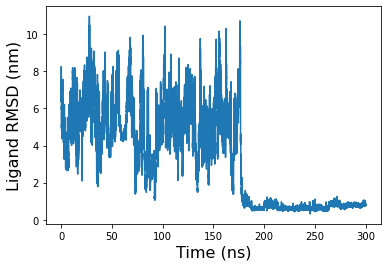

In [20]:
plt.plot(time, lig_rmsds[1])
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Ligand RMSD (nm)', fontsize=16)

In [29]:
np.save('lowest_lig_rmsd.npy', lig_rmsds[1])